In [1]:
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import datetime
from tensorflow_addons.layers import StochasticDepth
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler



import ssl

ssl._create_default_https_context = ssl._create_unverified_context

tf.get_logger().setLevel('ERROR')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Preparazione iperparametri di addestramento


In [2]:
projection_dim = 128
num_heads = 2
transformer_units = [projection_dim, projection_dim, projection_dim]
transformer_layers = len(transformer_units)
dropout = 0.25

learning_rate = 5e-3
weight_decay = 1e-5
batch_size = 256
num_epochs = 500
image_size = 32


#### Importazione del dataset

In [3]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


#### Creo la classe CCTTokenaizer che mi permette tramite una rete convolutiva di estrarre le features dalle immagini e un positional embedding che terra traccia della posizione delle features sulla quale poi il modello effettuera le previsioni

In [4]:
class CCTTokenizer(tf.keras.layers.Layer):
    def __init__(
        self,
        kernel_size = 3,
        stride = 1,
        padding = 1,
        pooling_kernel_size = 3,
        pooling_stride = 2,
        num_output_channels = [64, 128],
        **kwargs
    ):
        super(CCTTokenizer, self).__init__(**kwargs)
        # sotto-rete convolutiva che fa da tokenizzatore
        self.conv_model = tf.keras.Sequential()
        for i in range(len(num_output_channels)):
            self.conv_model.add(tf.keras.layers.Conv2D(num_output_channels[i], kernel_size, stride, padding = "valid", activation = "swish"))
            self.conv_model.add(tf.keras.layers.ZeroPadding2D(padding))
            self.conv_model.add(tf.keras.layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))



    def call(self, images):
        outputs = self.conv_model(images)
        # cambio di dimensionalità per formare sequenze di feature estratte
        reshaped = tf.reshape(outputs, (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]),
                             )
        return reshaped

    def positional_embedding(self, image_size):
        # calcolo del numero di sequenze e inizializzazione del
        # layer di Embedding che verrà utilizzato successivamente
        # per il calcolo degli embedding posizionali
        dummy_inputs = tf.zeros((1, image_size, image_size, 3))
        dummy_outputs = self.call(dummy_inputs)
        sequence_length = tf.shape(dummy_outputs)[1]
        projection_dim = tf.shape(dummy_outputs)[-1]

        embed_layer = tf.keras.layers.Embedding(input_dim = sequence_length, output_dim = projection_dim)
        return embed_layer, sequence_length




#### Rete neurale feedforward multi-layer (MLP), anche conosciuta come rete fully connected

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="swish")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

#### Data agumentation per aumentare le dimensionalita del dataset

In [6]:
data_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.Rescaling(scale=1.0 / 255),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomRotation(0.1)
    ],
    name="data_augmentation",
)

#### Architettura Compact convolutional trasformer

In [8]:
def create_cct_model(
    image_size = image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = tf.keras.layers.Input(input_shape)

    augmented = data_augmentation(inputs)

    # codifica delle "patches":
    # nei CCT non sono pezzi dell'immagine (in pxl) di input
    # ma sequenze di feature estratte
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # impostazione del positional embedding
    # sommo il positional Embedding all'uscita del tokenizer
    # in modo che le feature-map abbiano al loro interno anche la posizione
    pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
    positions = tf.range(start = 0, limit = seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    encoded_patches += position_embeddings




    for i in range(transformer_layers):
        # Layer Normalization
        x1 = tf.keras.layers.LayerNormalization(epsilon = 1e-5)(encoded_patches)
        # MultiHeadAttention
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = 256, dropout=0.1)(x1, x1)
        # Skip Connection
        attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
        x2 = StochasticDepth(survival_probability= 0.25)([encoded_patches, attention_output])
        # Layer normalization
        x3 = tf.keras.layers.LayerNormalization(epsilon = 1e-5)(x2)
        # MLP
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = dropout)
        # Skip Connection
        encoded_patches2 = StochasticDepth(survival_probability=0.25)([x2, x3])


    encoded_patches3 = StochasticDepth(survival_probability=0.25)([encoded_patches2, encoded_patches2])
    # Pooling sulle sequenze
    representation = tf.keras.layers.LayerNormalization(epsilon= 1e-5)(encoded_patches3)
    # "representation" ha dimensioni (batch, 64, 128) -> una sequenza di 64 elementi descritti su 128 dimensioni
    attention_weights = tf.nn.softmax(tf.keras.layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(attention_weights, representation, transpose_a=True)
    # -> (1, 64) * (64, 128) => (1, 128)

    weighted_representation = tf.squeeze(weighted_representation, -2)
    # squeeze((batch, 1, 128), -2) -> (batch, 128)

    # output (classificazione finale)
    logits = tf.keras.layers.Dense(num_classes)(weighted_representation)

    model = tf.keras.Model(inputs=inputs, outputs=logits)
    model.summary()

    tf.keras.utils.plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True, show_dtype=True, show_layer_activations=True)

    return model

#### Addestramento del modello con implementazioni di callback e tensorboard

In [9]:



def run_experiment(model, learning_rate, weight_decay):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = "checkpoint/"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="accuracy",
        save_best_only=True,
        save_weights_only=True,
    )


    def custom_lr_scheduler(epoch, lr):
      if lr < 1e-4:
          return 6e-3
      else:
          return lr

    lr_callback1 = LearningRateScheduler(custom_lr_scheduler)




    callback_LR = ReduceLROnPlateau(
        patience = 2,
        factor = 0.75,
        monitor = 'loss',
        mode = 'min',
        min_lr = 1e-5,
        verbose = 1)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, tensorboard_callback, callback_LR, lr_callback1]


    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    model.save_weights("Pesi_CCT.h5")
    return history




cct_model = create_cct_model()
history = run_experiment(cct_model, learning_rate, weight_decay)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 cct_tokenizer (CCTTokenize  (None, 64, 128)              75648     ['data_augmentation[0][0]']   
 r)                                                                                               
                                                                                              

#### Illustrazione risultati di addestramento se lo avessi lasciato addestrare piu epoche sarebbe migliorato ancora ho implementato l'aumento del learning rate perche intorno alla loss pari a 0.26 c'era un minimo locale che sono riuscito a fargli superare con successo grazie a questa tecnica

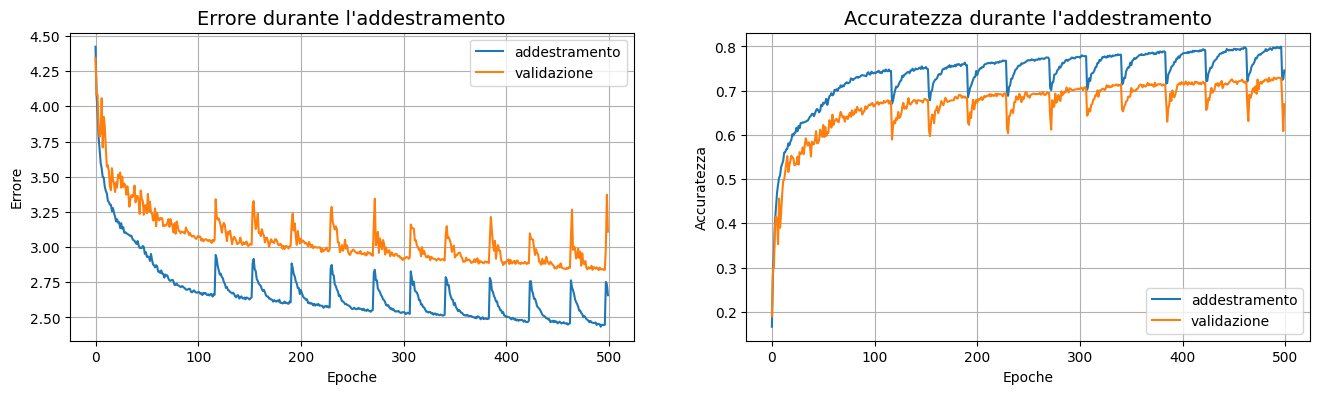

In [10]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(121)
ax1.plot(history.history["loss"], label="addestramento")
ax1.plot(history.history["val_loss"], label="validazione")
ax1.set_xlabel("Epoche")
ax1.set_ylabel("Errore")
ax1.set_title("Errore durante l'addestramento", fontsize=14)
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["top-5-accuracy"], label="addestramento")
ax2.plot(history.history["val_top-5-accuracy"], label="validazione")
ax2.set_xlabel("Epoche")
ax2.set_ylabel("Accuratezza")
ax2.set_title("Accuratezza durante l'addestramento", fontsize=14)
ax2.legend()
ax2.grid()

plt.show()